In [1]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.test.is_gpu_available else "NOT AVAILABLE")

TF version: 2.10.0
GPU is available


In [2]:
import numpy as np
import IPython.display as display
import PIL.Image
from keras.preprocessing import image

In [3]:
# 图像标准化
def normalize_image(img):
    img = 255 * (img + 1.0) / 2.0
    return tf.cast(img, tf.uint8)

# 图像可视化
def show_image(img):
    display.display(PIL.Image.fromarray(np.array(img)))

# 保存图像文件
def save_image(img, file_name):
    PIL.Image.fromarray(np.array(img)).save('save/' + file_name)

In [4]:
# 导入ImageNet数据集的图像识别预训练InceptionV3模型
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
base_model.summary()

Metal device set to: Apple M1 Pro


2022-11-11 10:27:26.559602: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-11 10:27:26.559764: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [5]:
# 最大限度地激活这些层的指定的层
layer_names = 'conv2d_15'
layers = base_model.get_layer(layer_names).output
layers

<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_15')>

In [6]:
# 创建特征提取模型
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
dream_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [7]:
def calc_loss (img, model):
    channel=13 # 选定第13通道
    # 对图象做变形，由 （300，300，3）扩展为（1，300,300, 3)
    img = tf.expand_dims(img, axis=0)
    # 图像通过模型前向传播得到计算结果
    layer_activations = model(img)
    # 取选中通道的值
    act = layer_activations[:,:,:,channel]
    # 选中通道的粉出结果求均值
    return tf.math.reduce_mean(act)

# 定义图像优化过程函数
def render_deepdream(model, img, steps=100, step_size=0.01, verbose=1):
    for n in tf.range(steps):
        with tf.GradientTape() as tape:
            # 对img进行梯度变换
            tape.watch(img)
            loss = calc_loss(img, model)
        # 计算损失相对于粉入图像像素的梯度
        gradients = tape.gradient(loss, img)
        # 归一化梯度值
        gradients /= tf.math.reduce_std(gradients) + 1e-8
        # 在梯度上开中，损失值越来越大，因此可以直接添加损失值到图像中， 因为它们的shape相同
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)
        # 粉出过程提示信息
        if verbose ==1:
            if (n + 1) %10==0:
                print ("Step {}/{}, loss {})". format (n+1, steps, loss))
    return img

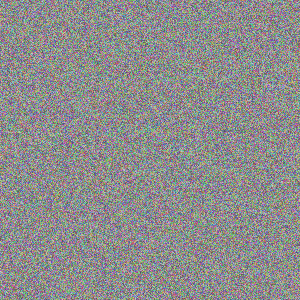

In [8]:
# 定义图像噪声
img_noise = np.random.uniform (size= (300, 300, 3)) + 100.0
img_noise = img_noise.astype(np.float32)  # dtype 转换成 float32
show_image(normalize_image(img_noise))

img = tf.keras.applications.inception_v3.preprocess_input(img_noise)
img = tf.convert_to_tensor(img)

开始做梦...
Step 10/100, loss 2.2152483463287354)
Step 20/100, loss 3.458974838256836)
Step 30/100, loss 4.275025367736816)
Step 40/100, loss 4.85901403427124)
Step 50/100, loss 5.341507434844971)
Step 60/100, loss 5.75860071182251)
Step 70/100, loss 6.133041858673096)
Step 80/100, loss 6.486417770385742)
Step 90/100, loss 6.818798065185547)
Step 100/100, loss 7.133233547210693)
梦醒时分... 耗时: 5.374534845352173


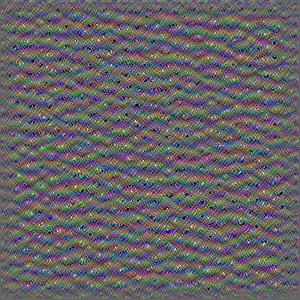

梦境已保存为:deep_dream_conv2d_15.jpg


In [10]:
import time

start = time.time()
print('开始做梦...')

# 调用优化过程
dream_img = render_deepdream(dream_model, img, steps=100, step_size=0.01)

end = time.time()
print('梦醒时分... 耗时:', end - start)

# 标准化图像
dream_img = normalize_image(dream_img)

# 显示结果图像
show_image(dream_img)

# 保存结果
file_name = 'deep_dream_{}.jpg'.format(layer_names)
save_image(dream_img, file_name)
print('梦境已保存为:{}'.format(file_name))

In [11]:
def read_image(file_name, max_dim=None):
    img = PIL.Image.open(file_name)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

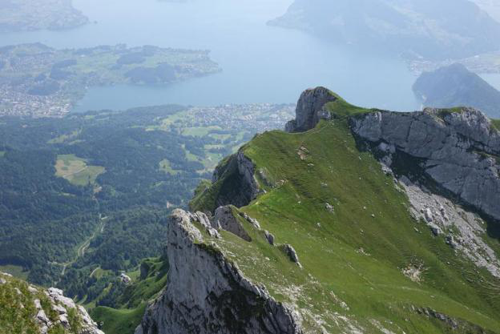

In [17]:
image_file = 'mountain.jpg'
img_mountain = read_image('data/' + image_file, max_dim=500)
show_image(img_mountain)

img = tf.keras.applications.inception_v3.preprocess_input(img_mountain)
img = tf.convert_to_tensor(img)

开始做梦...
Step 10/100, loss 2.6708483695983887)
Step 20/100, loss 3.712336540222168)
Step 30/100, loss 4.389425754547119)
Step 40/100, loss 4.905730724334717)
Step 50/100, loss 5.334399223327637)
Step 60/100, loss 5.707415580749512)
Step 70/100, loss 6.045620441436768)
Step 80/100, loss 6.3592448234558105)
Step 90/100, loss 6.6664042472839355)
Step 100/100, loss 6.966397285461426)
梦醒时分... 耗时: 5.742219924926758


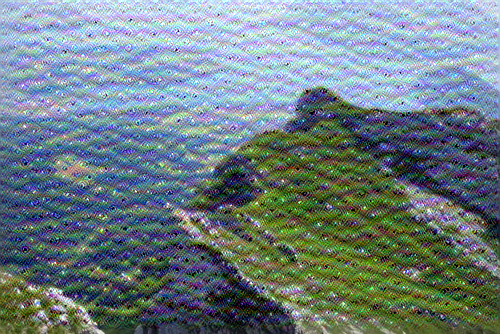

梦境已保存为:mountain_deep_dream_conv2d_15.jpg


In [18]:
import time

start = time.time()
print('开始做梦...')

# 调用优化过程
dream_img = render_deepdream(dream_model, img, steps=100, step_size=0.01)

end = time.time()
print('梦醒时分... 耗时:', end - start)

# 标准化图像
dream_img = normalize_image(dream_img)

# 显示结果图像
show_image(dream_img)

# 保存结果
file_name = 'mountain_deep_dream_{}.jpg'.format(layer_names)
save_image(dream_img, file_name)
print('梦境已保存为:{}'.format(file_name))